# Rede Neural Recorrente simples para classificar dígitos MNIST

Este experimento ilustra o uso de uma rede neural recorrente na tarefa de classificação
de dígitos manuscritos do dataset MNIST.

A imagem é estruturada em 28 sequências de 28 pixels cada. Cada elemento da sequência é
formado por uma linha da imagem. Cada linha da imagem contém 28 atributos (pixels).

<img src='../figures/RNN_MNIST.png', width= 700></img>

**Obs:** Este experimento foi inspirado no artigo:
"A Simple Way to Initialize Recurrent Networks of Rectified Linear Units"
by Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton
arxiv:1504.00941v2 [cs.NE] 7 Apr 2015
http://arxiv.org/pdf/1504.00941v2.pdf

A principal modificação é a formatação da imagem em 28 sequências de 28 pixels.

## Importação

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
from   torch.autograd import Variable

import torchvision

import lib.pytorch_trainer as ptt
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do dataset

In [3]:
dataset_dir = '/data/datasets/MNIST/'

data_train, target_train = torch.load(dataset_dir + 'processed/training.pt')
data_test,  target_test  = torch.load(dataset_dir + 'processed/test.pt')

data_train = data_train.float() / 255.
data_test  = data_test.float() / 255.

## Pouquíssimas amostras - depurando apenas

In [5]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500
else:
    n_samples_train = data_train.size(0)
    n_samples_test  = data_test.size(0)
    
x_train = data_train[:n_samples_train].clone()
y_train = target_train[:n_samples_train].clone()
x_test  = data_test[:n_samples_test].clone()
y_test  = target_test[:n_samples_test].clone()
del data_train, target_train, data_test, target_test

In [6]:
x_train.shape

torch.Size([1000, 28, 28])

## SimpleRNN com 100 neurônios

In [8]:
class Model_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(Model_RNN, self).__init__()
        self.rnn = nn.RNN(28, hidden_size, 1, batch_first=True, nonlinearity='relu', dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,x = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    

model_rnn = Model_RNN(100)
if use_gpu:
    model_rnn = model_rnn.cuda()
model_rnn

Model_RNN (
  (rnn): RNN(28, 100, batch_first=True, dropout=0.05)
  (out): Linear (100 -> 10)
)

## Predict com uma amostra

In [32]:
xin = x_train[0:2]
print('xin.shape:',xin.shape)
xv_in = Variable(xin)
if use_gpu:
    xv_in = xv_in.cuda()
ypred = model_rnn(xv_in)
print(torch.squeeze(ypred[:,:10]))

xin.shape: torch.Size([2, 28, 28])
Variable containing:

Columns 0 to 7 
 -0.1408  -5.5384   0.7653   1.1210 -15.1842   0.3694 -11.4713  -1.6769
  3.0954  -3.0685   0.4708  -0.9883  -7.3848   0.2567  -1.6035  -6.0274

Columns 8 to 9 
 -2.0571  -4.3757
 -1.5697  -1.8740
[torch.FloatTensor of size 2x10]



## Criando o treinador

In [11]:
chkpt_cb = ptt.ModelCheckpoint('../../models/SimpleRNN_MNIST_t', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model_rnn,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = torch.optim.Adam(model_rnn.parameters(),lr=1e-3),
                        callbacks = [chkpt_cb, ptt.AccuracyMetric(),ptt.PrintCallback()]
                        )

In [27]:
if True:
    trainer.fit(20, x_train, y_train, valid_data=(x_test, y_test),batch_size=32)
else:
    trainer.load_state('/data/models/SimpleRNN_MNIST_rnn')

Start training for 20 epochs
 21:   0.8s   T: 0.60491 0.80000   V: 0.82260 0.72600 best
 22:   0.7s   T: 0.51764 0.83200   V: 0.77415 0.74800 best
 23:   0.7s   T: 0.54383 0.84400   V: 0.78698 0.74600 
 24:   0.7s   T: 0.48250 0.85400   V: 0.74022 0.77600 best
 25:   0.7s   T: 0.43978 0.86400   V: 0.94426 0.73800 
 26:   0.8s   T: 0.46158 0.86200   V: 0.74491 0.78000 
 27:   0.8s   T: 0.37783 0.89500   V: 0.82677 0.77800 
Best model was saved at epoch 24 with loss 0.74022: ../../models/SimpleRNN_MNIST_t
Stop training at epoch: 27/40


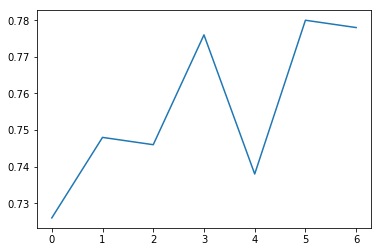

In [28]:
plt.plot(trainer.metrics['valid']['acc'])

## Usando LSTM

In [29]:
class Model_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Model_LSTM, self).__init__()
        self.rnn = nn.LSTM(28, hidden_size, 1, batch_first=True, dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,(x,_) = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    
model_lstm = Model_LSTM(100)
if use_gpu:
    model_lstm = model_lstm.cuda()

### Predict com uma amostra

In [33]:
xin = x_train[0:2]
print('xin.shape:',xin.shape)
xv_in = Variable(xin)
if use_gpu:
    xv_in = xv_in.cuda()
ypred = model_lstm(xv_in)
print(torch.squeeze(ypred[:,:10]))

xin.shape: torch.Size([2, 28, 28])
Variable containing:
 0.0863  0.0773  0.0372 -0.0987 -0.0949  0.0862  0.1062 -0.0467  0.0474  0.0955
 0.0855  0.0733  0.0374 -0.0978 -0.1026  0.0863  0.1016 -0.0459  0.0424  0.0947
[torch.FloatTensor of size 2x10]



### Criando o treinador

In [34]:
chkpt_cb = ptt.ModelCheckpoint('../../models/SimpleRNN_MNIST_lstm', reset=True, verbose=1)

trainer_lstm = ptt.DeepNetTrainer(
                model_lstm,
                criterion = nn.CrossEntropyLoss(),
                optimizer = torch.optim.Adam(model_lstm.parameters(),lr=1e-3),
                callbacks = [chkpt_cb, ptt.AccuracyMetric(),ptt.PrintCallback()]
                )

In [35]:
trainer_lstm.fit(20, x_train, y_train, valid_data=(x_test, y_test),batch_size=32)

Start training for 20 epochs
  1:   1.9s   T: 2.29543 0.14500   V: 2.26182 0.26200 best
  2:   2.1s   T: 2.05889 0.28200   V: 1.95243 0.33600 best
  3:   2.0s   T: 1.52679 0.49600   V: 1.33567 0.52000 best
Best model was saved at epoch 3 with loss 1.33567: ../../models/SimpleRNN_MNIST_lstm
Stop training at epoch: 4/20


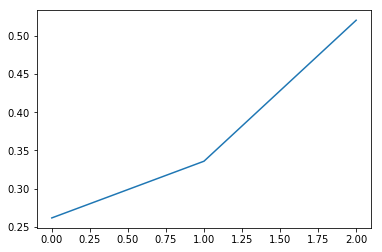

In [36]:
plt.plot(trainer_lstm.metrics['valid']['acc'])

## Comparação RNN x LSTM

    - Acurácia RNN: 97,5%
    - Acurácia LSTM: 98,9%

# Exercícios

In [ ]:
1. 